## Agregação por distrito

Nesse notebook é feita a agregação dos dados por distritos do município

In [1]:
import geopandas as gpd
import random
from shapely.geometry import LineString
from utils.save_shp import save_shp
from utils.load_csv import load_csv
from utils.load_shp import load_shp

In [2]:
df_final = load_csv("df_final.csv")

distritos = load_shp("distritos.shp")

In [3]:
df_final["lon"] = df_final["ponto_inicial"].apply(lambda x: eval(x)[0])
df_final["lat"] = df_final["ponto_inicial"].apply(lambda x: eval(x)[1])

In [4]:
gdf = gpd.GeoDataFrame(df_final, geometry=gpd.points_from_xy(df_final.lon, df_final.lat), crs="EPSG:4326")

In [5]:
gdf.head()

,id_onibus,distancia_percorrida,ponto_inicial,ponto_final,momento_inicial,momento_final,modelo,litro_diesel_km,emissao_no2,emissao_co2,is_eletrico,lon,lat,geometry
0,41610,0.001100,"[-46.546797, -23.5194545]","[np.float64(-46.547896), np.float64(-23.519413...",2025-09-03 11:27:39+00:00,2025-09-03 11:28:24+00:00,Articulado (23m),0.85,0.000020,0.000092,True,-46.546797,-23.519454,POINT (-46.5468 -23.51945)
1,41610,0.000000,"[-46.547896, -23.519413375]","[np.float64(-46.547896), np.float64(-23.519413...",2025-09-03 11:28:24+00:00,2025-09-03 11:28:24+00:00,Articulado (23m),0.85,0.000000,0.000000,True,-46.547896,-23.519413,POINT (-46.5479 -23.51941)
2,41610,0.003288,"[-46.547896, -23.519413375]","[np.float64(-46.550168), np.float64(-23.521789...",2025-09-03 11:28:24+00:00,2025-09-03 11:29:54+00:00,Articulado (23m),0.85,0.000059,0.000276,True,-46.547896,-23.519413,POINT (-46.5479 -23.51941)
3,41610,0.001866,"[-46.550168, -23.52178975]","[np.float64(-46.5514535), np.float64(-23.523143)]",2025-09-03 11:29:54+00:00,2025-09-03 11:30:38+00:00,Articulado (23m),0.85,0.000033,0.000157,False,-46.550168,-23.521790,POINT (-46.55017 -23.52179)
4,41610,0.001959,"[-46.5514535, -23.523143]","[np.float64(-46.55280175), np.float64(-23.5245...",2025-09-03 11:30:38+00:00,2025-09-03 11:31:23+00:00,Articulado (23m),0.85,0.000035,0.000165,True,-46.551454,-23.523143,POINT (-46.55145 -23.52314)


In [6]:
dropar = gdf['id_onibus'].value_counts()[(gdf['id_onibus'].value_counts() == 1)].index

gdf = gdf[~gdf['id_onibus'].isin(dropar)].reset_index(drop=True)

In [7]:
trajetos = gdf.groupby("id_onibus")["geometry"].apply(lambda x: LineString(x.tolist()))
trajetos = gpd.GeoDataFrame(trajetos, geometry="geometry", crs="EPSG:4326").reset_index()

In [8]:
trajetos.head()

,id_onibus,geometry
0,3117,"LINESTRING (-46.55774 -23.58089, -46.55985 -23..."
1,3203,"LINESTRING (-46.48961 -23.57029, -46.48961 -23..."
2,7302,"LINESTRING (-46.77834 -23.69281, -46.77834 -23..."
3,7311,"LINESTRING (-46.67678 -23.61901, -46.7701 -23...."
4,7316,"LINESTRING (-46.78584 -23.73095, -46.78584 -23..."


In [9]:
agregados = gdf.groupby("id_onibus").agg({
    "emissao_co2": "sum"       
}).reset_index()

trajetos = trajetos.merge(agregados, on="id_onibus", how="left")

In [10]:
trajetos

,id_onibus,geometry,emissao_co2
0,3117,"LINESTRING (-46.55774 -23.58089, -46.55985 -23...",0.000617
1,3203,"LINESTRING (-46.48961 -23.57029, -46.48961 -23...",0.000000
2,7302,"LINESTRING (-46.77834 -23.69281, -46.77834 -23...",0.000036
3,7311,"LINESTRING (-46.67678 -23.61901, -46.7701 -23....",0.035514
4,7316,"LINESTRING (-46.78584 -23.73095, -46.78584 -23...",0.000020
...,...,...,...
11488,86604,"LINESTRING (-46.69382 -23.5657, -46.69382 -23....",0.000390
11489,86607,"LINESTRING (-46.72817 -23.62348, -46.72817 -23...",0.000786
11490,86608,"LINESTRING (-46.70987 -23.60138, -46.7089 -23....",0.000804
11491,86609,"LINESTRING (-46.69881 -23.5871, -46.69881 -23....",0.000656


<Axes: >

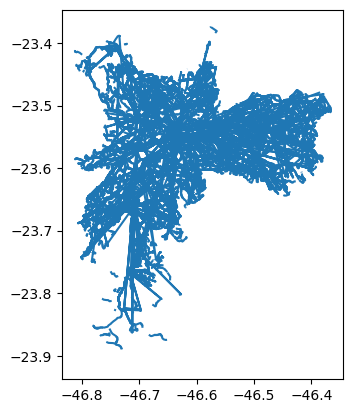

In [11]:
trajetos.plot()

21490


<Axes: >

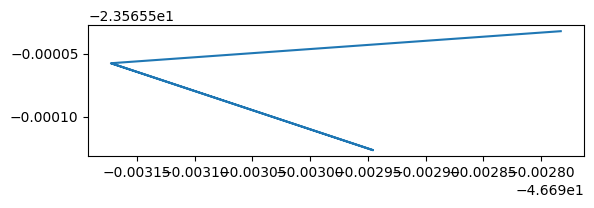

In [33]:
onibus_aleatorio = random.choice(trajetos['id_onibus'].unique().tolist())

print(onibus_aleatorio)
trajetos[trajetos['id_onibus'] == onibus_aleatorio].plot()

In [ ]:
trajetos = trajetos.to_crs(distritos.crs)

In [ ]:
trajetos_distritos = gpd.sjoin(trajetos, distritos, how="inner", predicate="intersects")

trajetos_distritos

,id_onibus,geometry,emissao_co2,index_right,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me
0,3117,"LINESTRING (341038.714 7391308.416, 340823.043...",0.000617,4,8583416.0,29.0,72,SAO LUCAS,SLU,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.674,9674427.42
0,3117,"LINESTRING (341038.714 7391308.416, 340823.043...",0.000617,53,8583437.0,29.0,93,VILA PRUDENTE,VPR,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.525,9525461.96
0,3117,"LINESTRING (341038.714 7391308.416, 340823.043...",0.000617,90,8583441.0,25.0,1,AGUA RASA,ARA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.177,7177175.74
1,3203,"LINESTRING (347979.815 7392556.402, 347979.815...",0.000000,82,8583464.0,27.0,24,CIDADE LIDER,CLD,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,10.356,10356058.83
2,7302,"LINESTRING (318676.419 7378652.117, 318676.419...",0.000036,75,8583438.0,18.0,43,JARDIM ANGELA,JDA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,36.364,36363863.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11492,90999,"LINESTRING (336497.083 7388817.116, 357741.673...",0.010911,43,8583417.0,30.0,73,SAO MATEUS,SMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,12.800,12800219.28
11492,90999,"LINESTRING (336497.083 7388817.116, 357741.673...",0.010911,0,8583465.0,31.0,25,CIDADE TIRADENTES,CTI,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,14.939,14939046.96
11492,90999,"LINESTRING (336497.083 7388817.116, 357741.673...",0.010911,77,8583400.0,27.0,57,PARQUE DO CARMO,PQC,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,15.476,15476003.74
11492,90999,"LINESTRING (336497.083 7388817.116, 357741.673...",0.010911,16,8583485.0,27.0,47,JOSE BONIFACIO,JBO,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,14.570,14569748.72


In [ ]:
gdf_overlay = gpd.overlay(trajetos, distritos, how="intersection")

gdf_overlay['distancia'] = gdf_overlay.geometry.length

gdf_overlay

,id_onibus,emissao_co2,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me,geometry,distancia
0,3117,0.000617,8583416.0,29.0,72,SAO LUCAS,SLU,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.674,9674427.42,"LINESTRING (341038.714 7391308.416, 340823.043...",449.337869
1,3117,0.000617,8583437.0,29.0,93,VILA PRUDENTE,VPR,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.525,9525461.96,"MULTILINESTRING ((340129.748 7391267.629, 3401...",340.110153
2,3117,0.000617,8583441.0,25.0,1,AGUA RASA,ARA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.177,7177175.74,"MULTILINESTRING ((340596.958 7391277.489, 3401...",595.633830
3,3203,0.000000,8583464.0,27.0,24,CIDADE LIDER,CLD,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,10.356,10356058.83,LINESTRING EMPTY,0.000000
4,7302,0.000036,8583438.0,18.0,43,JARDIM ANGELA,JDA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,36.364,36363863.45,"LINESTRING (318676.419 7378652.117, 318661.148...",18.558657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16743,90999,0.010911,8583420.0,32.0,76,SAPOPEMBA,SAP,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.633,13632901.77,"LINESTRING (343847.2 7389324.496, 347414.66 73...",3575.950329
16744,90999,0.010911,8583417.0,30.0,73,SAO MATEUS,SMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,12.800,12800219.28,"LINESTRING (347414.66 7389570.758, 350732.212 ...",3325.446360
16745,90999,0.010911,8583437.0,29.0,93,VILA PRUDENTE,VPR,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.525,9525461.96,"MULTILINESTRING ((338609.904 7388962.964, 3388...",2563.922247
16746,90999,0.010911,8583400.0,27.0,57,PARQUE DO CARMO,PQC,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,15.476,15476003.74,"LINESTRING (350732.212 7389799.77, 351312.998 ...",582.168683


In [ ]:
gdf_distrito = gdf_overlay.groupby('nm_distrit').agg({
    'distancia':'sum',
    "emissao_co2": 'sum'
}).reset_index()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

distritos = distritos.merge(gdf_distrito, on='nm_distrit', how='left')
distritos_final = distritos.fillna(0)

In [ ]:
distritos_final['is_eletrico'] = [random.choice([True, False]) for i in range(len(distritos_final))]

In [ ]:
warnings.filterwarnings("ignore", category = RuntimeWarning)
warnings.filterwarnings("ignore", category = UserWarning)

save_shp(distritos_final, "distritos_final.shp")

Shapefile salvo em data\distritos_final.shp
